# Classification Model for Discord’s users feedback (NLP) 
*Author: [Sheila Torrico](http://linkedin.com/in/sheilatorrico/)*

## Problem Statement

Many companies understand that providing a great customer experience is key for the success of a service or product. Customer Service is not only about fixing some billing questions or technical issues that customer face but also engaging their customer base to provide feedback on their experience. 

Companies, such as Discord, have opened public feedback forums that customers can leverage to send improvement suggestions for Discord’s API for example. However, some feedback is not correctly classified within the available categories (API, Mobile, Other, etc) causing to be missed by Discord customer service team. 


## Project Goal

The goal of my project is to answer the following question: **Is it possible to classify submitted Feedback topics to their proper category given their text?**


## Dataset

The historical data that will use to answer this question was scraped from Discord’s Feedback site and covers Dec, 2018 to Feb 2019.

## Phase Covered
1. Data Cleaning/Transformation
1. Split of dataset: Train/Test
1. Feature Engineering
1. Modeling for Scenario 1: Text data does not contain Stopwords 
1. Modeling for Scenario 2: Text data contains Stopwords
1. Model Performance Evaluation
1. Model Improvement: Removing Categories/Hyperparameter tuning

In [1]:
%matplotlib inline

import spacy
import pandas as pd
import numpy as np
import re
from contractions import CONTRACTION_MAP
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [2]:
nlp = spacy.load('en')

In [3]:
dcorpora = pd.read_csv("../data/Capstone2/discordr3.csv")

# Data Pre-processing & Wrangling

In [4]:
# Obtain dataset information
dcorpora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4613 entries, 0 to 4612
Data columns (total 3 columns):
short descr    4613 non-null object
votes          4613 non-null int64
categories     4613 non-null object
dtypes: int64(1), object(2)
memory usage: 108.2+ KB


In [5]:
# First 5 observations 
dcorpora.head()

,short descr,votes,categories
0,Spoilers And Code,0,Chat
1,UI - Spoiler Below Spell Check Suggestions,0,Chat
2,Hover to Show Spoilers,4,Chat
3,Seen Feature for DMs/Servers,0,Chat
4,Chat translation,3,Chat


In [6]:
# Calculate number of observations per category
dcorpora['categories'].value_counts()

Chat                   1260
Other                  1253
Account Server Mgmt    1078
Mobile                  386
API                     300
Game Store              177
Overlay                 140
Merchandise              19
Name: categories, dtype: int64

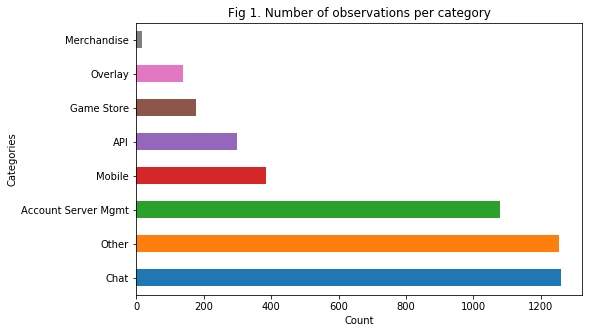

In [7]:
# Plot categories and their values
fig = plt.figure(figsize=(8,5))
dcorpora['categories'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Fig 1. Number of observations per category')
plt.show()

In [8]:
# Random inspection of observations 
dcorpora['short descr'].iloc[10:20]

10                                     Spoiler Settings
11                          Refine the spoiler markdown
12     Mentions role config of server or config of chat
13    Make it so that those with the admin permissio...
14                         Closing discord by mistake..
15                             Ping offline people too!
16       Extended block @everyone but for server ranks 
17                                          Locked text
18                                    turn off spoilers
19              Ability to send Direct Messages to self
Name: short descr, dtype: object

Text(0.5, 1.0, 'Histogram of topics length')

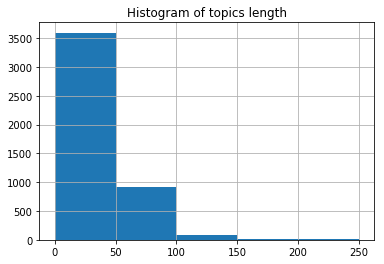

In [10]:
# Plot histogram of submitted topics length 
lens = dcorpora['short descr'].str.len()
lens.hist(bins = np.arange(0,300,50))
plt.title("Histogram of topics length")

In [11]:
# Transform short description data to lowercase 
dcorpora['lower'] = dcorpora['short descr'].apply(lambda x: x.lower())

In [12]:
# Confirm that lowercasing took place
dcorpora.tail()

,short descr,votes,categories,lower
4608,able to see how long someone has played a game...,6,Mobile,able to see how long someone has played a game...
4609,Check reaction name on mobile,12,Mobile,check reaction name on mobile
4610,Server shortcut widget,14,Mobile,server shortcut widget
4611,Organized Emote Picker,1,Mobile,organized emote picker
4612,Allow us to select multiple images at once whe...,15,Mobile,allow us to select multiple images at once whe...


In [13]:
# Random inspection of lower column observations
dcorpora['lower'].iloc[100:140]

100                                    favoriting images
101        more mention features (playing x, in y voice)
102    add real name id next to username (for friends...
103                        adjustable message editor box
104                                      voice messages 
105    please add a feature that allows you to mass d...
106                add the welsh flag as an emoji please
107    quick switcher - quickly switching is frustrat...
108             removing pings when user leaves group dm
109                         answer directly to a message
110                                  can't send pictures
111    a feature to hide messages without blocking th...
112    support end-to-end encryption for direct messa...
113                             a way to move a messages
114                                 edit user’s messages
115                                 incorrect emoji name
116                                 role-locked channels
117                            

## Cleaning and Transforming text

In [14]:
# Create function to remove contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [15]:
# Create function to remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [16]:
# Create function to remove all accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [17]:
# Create function to find root of each word using Lemmatization
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [18]:
# Create function to remove []
def remove_square_brackets(text):
    return re.sub(r'[\[\]]', '', text)

In [19]:
remove_square_brackets("[suggestions]")

'suggestions'

In [20]:
# Create function to remove ticks
def remove_tick(text):
    return re.sub(r'`',' ', text)

In [21]:
remove_tick('use `` ` diff')

'use      diff'

In [22]:
# Consolidate all functions in an Uber function
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, 
                     special_char_removal=True, text_lemmatization=True, 
                     bracket_removal = True, tick_removal = True):   
 
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc) 
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove bracket
        if bracket_removal:
            doc = remove_square_brackets(doc)
        # remove tick
        if tick_removal:
            doc = remove_tick(doc)    
             
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [23]:
# Check that normalization takes place
norm_reviews = normalize_corpus(["Héllo! Hüg! can't you l~~istening [me]! @ ęll"],contraction_expansion=True,
                     accented_char_removal=True, 
                     special_char_removal=True, text_lemmatization=True, 
                     bracket_removal = True, tick_removal=True)   
print(norm_reviews)

['hello hug can not you listen  me    ell']


In [24]:
# Extract the text observations into an array
feedback = np.array(dcorpora['lower'])
feedback

array(['spoilers and code', 'ui - spoiler below spell check suggestions',
       'hover to show spoilers', ..., 'server shortcut widget',
       'organized emote picker',
       'allow us to select multiple images at once when uploading'],
      dtype=object)

In [25]:
# Normalize the text observations: Clean Corpus
norm_reviews = normalize_corpus(feedback, contraction_expansion=True,
                     accented_char_removal=True, 
                     special_char_removal=True, text_lemmatization=True, 
                     bracket_removal = True, tick_removal=True)
print(norm_reviews)

['spoiler and code', 'ui   spoiler below spell check suggestion', 'hover to show spoiler', 'see feature for dmsserver', 'chat translation', 'add message quoting', 'spoiler for mp4 file', 'spoiler feedback', 'spoilerwhat a waste', 'block word', 'spoiler setting', 'refine the spoiler markdown', 'mention role config of server or config of chat', 'make it so that those with the admin permission can automatically see spoiler therefore prevent misuse of the spoiler feature', 'close discord by mistake', 'ping offline people too', 'extended block everyone but for server rank', 'lock text', 'turn off spoiler', 'ability to send direct message to self', 'disable markup in embed that discord create from url', 'make gif actual gif instead of link', 'do not make it possible to copy spoiler text by select it without reveal', 'prevent texttospeech from read spoiler', 'guy will be guy   18 spoiler filter', 'open all spoiler button', 'search for spoiler', 'reopen old dms', 'let us turn off gif picker an

Decided against adding a 'non_english' value to blank rows since it will create more trash signal

In [26]:
# Run statistical functions on 'votes' column
dcorpora['votes'].describe()

count     4613.000000
mean        18.558205
std        355.261912
min        -53.000000
25%          0.000000
50%          4.000000
75%         12.000000
max      20498.000000
Name: votes, dtype: float64

Text(0.5, 1.0, 'Distribution of Votes')

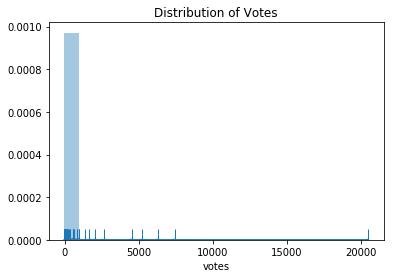

In [28]:
#Plot the density probability
x = dcorpora['votes']
_= sns.distplot(x, bins= 20, rug=True)
plt.title('Distribution of Votes')

In [29]:
# Find the vote observation with the most votes
dcorpora.loc[dcorpora['votes'] == 20498]

,short descr,votes,categories,lower
3935,Account descriptions,20498,Account Server Mgmt,account descriptions


In [30]:
# Find the vote observation with the least votes
dcorpora.loc[dcorpora['votes'] == -53]

,short descr,votes,categories,lower
1632,Discord should add so if you have nitro you ca...,-53,Other,discord should add so if you have nitro you ca...


In [31]:
# Display the least liked suggestion 
dcorpora['lower'].iloc[1632]

'discord should add so if you have nitro you can change your discord tag to c4 like csgos or just normal emojis but then also have a second discord tag that you can use when someone is trying to add you'

In [32]:
# Identify categories with neutral sentiment
neutral = dcorpora.loc[dcorpora['votes'] == 0]

In [33]:
# Calculate how many neutral observations within each category
neutral['categories'].value_counts()

Other                  173
Chat                   118
Account Server Mgmt    106
API                     32
Mobile                  26
Overlay                 16
Game Store              11
Name: categories, dtype: int64

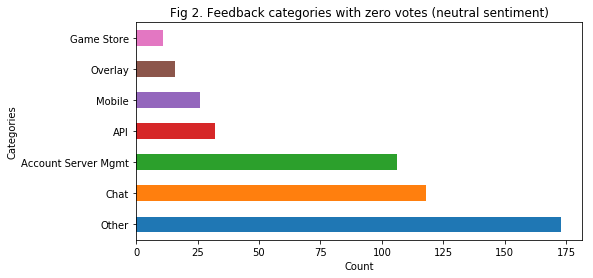

In [34]:
# Plot the categories with Neutral sentiment
fig = plt.figure(figsize=(8,4))
neutral['categories'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Fig 2. Feedback categories with zero votes (neutral sentiment)')
plt.show()

In [35]:
# Concat Normalized corpus column with orinigal dataframe
cleanpd = pd.concat([dcorpora, pd.DataFrame(norm_reviews)], axis=1)
cleanpd.head()

,short descr,votes,categories,lower,0
0,Spoilers And Code,0,Chat,spoilers and code,spoiler and code
1,UI - Spoiler Below Spell Check Suggestions,0,Chat,ui - spoiler below spell check suggestions,ui spoiler below spell check suggestion
2,Hover to Show Spoilers,4,Chat,hover to show spoilers,hover to show spoiler
3,Seen Feature for DMs/Servers,0,Chat,seen feature for dms/servers,see feature for dmsserver
4,Chat translation,3,Chat,chat translation,chat translation


In [36]:
# Rename Normalized corpus column
cleanpd.rename(columns={ cleanpd.columns[4]: "clean descr" },inplace=True)
cleanpd.head()

,short descr,votes,categories,lower,clean descr
0,Spoilers And Code,0,Chat,spoilers and code,spoiler and code
1,UI - Spoiler Below Spell Check Suggestions,0,Chat,ui - spoiler below spell check suggestions,ui spoiler below spell check suggestion
2,Hover to Show Spoilers,4,Chat,hover to show spoilers,hover to show spoiler
3,Seen Feature for DMs/Servers,0,Chat,seen feature for dms/servers,see feature for dmsserver
4,Chat translation,3,Chat,chat translation,chat translation


In [37]:
# To remove the extra spaces within ' ', use 'for loop' after making it a list
descs = cleanpd['clean descr'].tolist()

descs = [item.strip() for item in descs]

cleanpd['clean descr'] = descs


In [38]:
# Only keep the non-NaN observations
descriptions = cleanpd[cleanpd['clean descr'] != '']

In [39]:
# Verify if dataframe was created
print(type(descriptions))

<class 'pandas.core.frame.DataFrame'>


In [40]:
# Observe observations within dataframe
descriptions.head()

,short descr,votes,categories,lower,clean descr
0,Spoilers And Code,0,Chat,spoilers and code,spoiler and code
1,UI - Spoiler Below Spell Check Suggestions,0,Chat,ui - spoiler below spell check suggestions,ui spoiler below spell check suggestion
2,Hover to Show Spoilers,4,Chat,hover to show spoilers,hover to show spoiler
3,Seen Feature for DMs/Servers,0,Chat,seen feature for dms/servers,see feature for dmsserver
4,Chat translation,3,Chat,chat translation,chat translation


In [41]:
# View shape of dataframe
descriptions.shape

(4529, 5)

In [42]:
# Create new dataframe with Normalized/clean data
mdiscord = descriptions[['clean descr', 'votes', 'categories']]
mdiscord.shape

(4529, 3)

In [43]:
# Confirm first 5 observations 
mdiscord.head()

,clean descr,votes,categories
0,spoiler and code,0,Chat
1,ui spoiler below spell check suggestion,0,Chat
2,hover to show spoiler,4,Chat
3,see feature for dmsserver,0,Chat
4,chat translation,3,Chat


In [44]:
# Randomly inspect observations
mdiscord['clean descr'].iloc[75:100]

75                    feature custom background for chat
76            feature request add a voicemessage feature
77                                   why tts do not work
78               feature request easily reorder reaction
79     new message indicator do not always disappear ...
80     feature request private   specific user pushto...
81                     edit image in edit message window
83                                          server emoji
84                                  right click addition
85      intelligent notification base on recent activity
86     add the ability to search for specific file by...
87                                  step to send picture
88     remove the theme message display and scalingzo...
89     can we get a feature to scroll up to past mess...
90                                        high pin limit
91                                        reverse italic
92                                 gif picker rightclick
93                             

In [45]:
# Drop duplicates from dataframe 
ndiscord= mdiscord.drop_duplicates(inplace=False)

In [46]:
# Confirm that Merchandinse category no longer has NaN observations
ndiscord.loc[ndiscord['categories'] == 'Merchandise']

,clean descr,votes,categories
3750,wumpus plusie,5,Merchandise
3751,merch should be giftable through discord chat ...,26,Merchandise
3752,merch for verified server ownersteam,11,Merchandise
3754,will discord be sell pin on their website,15,Merchandise
3755,stream,15,Merchandise
3756,wumpus item,110,Merchandise
3757,onesie,15,Merchandise
3758,discord bandanna,16,Merchandise
3759,discord hoodie variety and idea,12,Merchandise
3760,ember mug,9,Merchandise


Text(0.5, 1.0, 'Histogram of Topics Length (post cleaning')

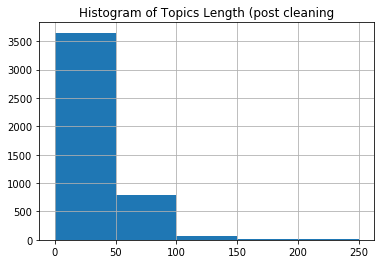

In [47]:
lenclean = ndiscord['clean descr'].str.len()
lenclean.hist(bins = np.arange(0,300,50))
plt.title('Histogram of Topics Length (post cleaning')

### Plot of Frequent Words (stop words included)

In [48]:
# Use for loop to create a list with the words within a sentence
wreview = np.array(ndiscord['clean descr'])
words = [word for sentence in wreview for word in sentence.split()]

In [49]:
# Apply Counter class to words list
Feed_counts = Counter(words)
print(Feed_counts)

Counter({'to': 977, 'the': 637, 'a': 561, 'discord': 542, 'for': 531, 'server': 458, 'in': 448, 'on': 424, 'be': 369, 'channel': 318, 'add': 311, 'and': 310, 'message': 267, 'of': 254, 'not': 246, 'role': 216, 'user': 215, 'chat': 207, 'mobile': 193, 'option': 188, 'game': 172, 'can': 162, 'make': 153, 'notification': 152, 'voice': 151, 'you': 150, 'when': 147, 'with': 144, 'feature': 141, 'i': 140, 'from': 137, 'allow': 137, 'emoji': 135, 'nitro': 133, 'new': 128, 'ability': 126, 'have': 126, 'it': 122, 'or': 121, 'change': 115, 'do': 110, 'account': 110, 'suggestion': 107, 'as': 103, 'permission': 101, 'spoiler': 98, 'text': 97, 'link': 96, 'bot': 95, 'button': 92, 'your': 91, 'app': 91, 'custom': 90, 'an': 89, 'list': 88, 'group': 87, 'profile': 87, 'support': 86, 'more': 85, 'gif': 83, 'that': 81, 'should': 79, 'friend': 79, 'member': 76, 'my': 76, 'use': 75, 'name': 73, 'call': 73, 'screen': 72, 'disable': 71, 'search': 71, 'image': 70, 'see': 69, 'setting': 69, 'people': 69, 'blo

In [50]:
# Calculate the x and y variables
Feed_common_words = [word[0] for word in Feed_counts.most_common(10)]
Feed_common_counts = [word[1] for word in Feed_counts.most_common(10)]

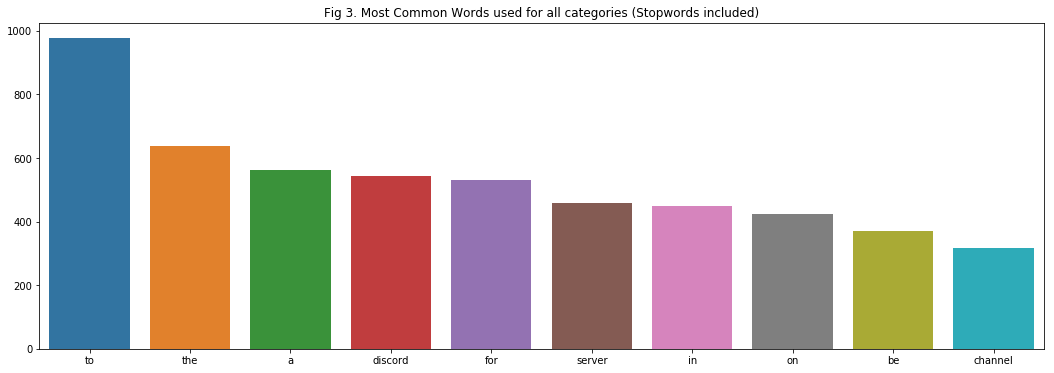

In [51]:
# Plot the most frequent words with stopwords
fig = plt.figure(figsize=(18,6))
sns.barplot(x=Feed_common_words, y=Feed_common_counts)
plt.title('Fig 3. Most Common Words used for all categories (Stopwords included)')
plt.show()

## Remove stopwords


In [52]:
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

In [53]:
# Create function to remove stopwords
def remove_stopwords(text, is_lower_case=True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [54]:
# Confirm that function works as intended
remove_stopwords('life is too short and precious, Moka has a big heart')

'life short precious , Moka big heart'

In [55]:
# Include remove stopwords function in Uber function
def norm_stop(corpus, words_removal = True):   
 
    normalized_c = []
    # normalize each document in the corpus
    for doc in corpus:
        if words_removal:
            doc = remove_stopwords(doc)
    # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
    
        normalized_c.append(doc)
        
    return normalized_c

In [56]:
# Extract clean text observations into an array
reviews = np.array(ndiscord['clean descr'])

In [57]:
# Apply Uber function on array 
all_reviews = norm_stop(reviews, words_removal = True)

In [58]:
# Create list with only words and apply Counter class 
wordsall = [word for sentence in all_reviews for word in sentence.split()]
Feed_all = Counter(wordsall)
print(Feed_all)

Counter({'discord': 542, 'server': 458, 'channel': 318, 'add': 311, 'message': 267, 'role': 216, 'user': 215, 'chat': 207, 'mobile': 193, 'option': 188, 'game': 172, 'make': 153, 'notification': 152, 'voice': 151, 'feature': 141, 'allow': 137, 'emoji': 135, 'nitro': 133, 'new': 128, 'ability': 126, 'change': 115, 'account': 110, 'suggestion': 107, 'permission': 101, 'spoiler': 98, 'text': 97, 'link': 96, 'bot': 95, 'button': 92, 'app': 91, 'custom': 90, 'list': 88, 'group': 87, 'profile': 87, 'support': 86, 'gif': 83, 'friend': 79, 'member': 76, 'use': 75, 'name': 73, 'call': 73, 'screen': 72, 'disable': 71, 'search': 71, 'image': 70, 'see': 69, 'setting': 69, 'people': 69, 'block': 68, 'mention': 67, 'specific': 67, 'delete': 66, 'overlay': 66, 'like': 65, 'hide': 64, 'show': 63, 'request': 63, 'status': 63, 'invite': 62, 'mode': 61, 'android': 60, 'color': 59, 'emote': 58, 'video': 57, 'able': 56, 'dm': 54, 'mute': 54, 'update': 54, 'way': 53, 'would': 52, 'window': 51, 'someone': 51

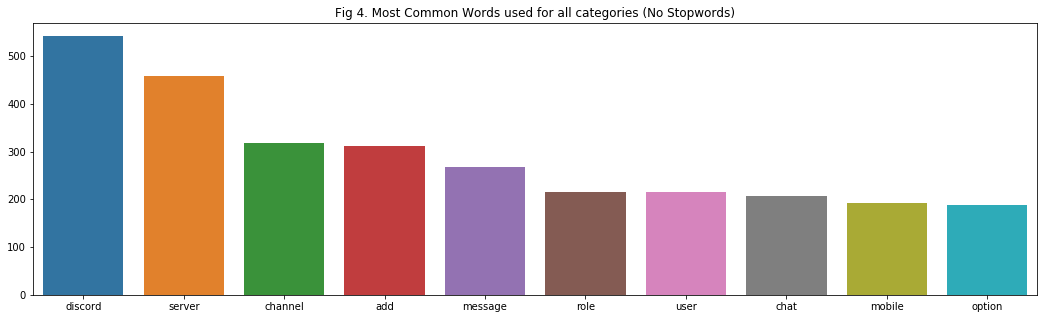

In [59]:
# Create x and y variables for plot
Feed_common_all = [word[0] for word in Feed_all.most_common(10)]
Feed_all_counts = [word[1] for word in Feed_all.most_common(10)]

# Plot most common words after extracting stopwords 
fig = plt.figure(figsize=(18,5))
sns.barplot(x=Feed_common_all, y=Feed_all_counts)
plt.title('Fig 4. Most Common Words used for all categories (No Stopwords)')
plt.show()

In [60]:
ndiscord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4526 entries, 0 to 4612
Data columns (total 3 columns):
clean descr    4526 non-null object
votes          4526 non-null int64
categories     4526 non-null object
dtypes: int64(1), object(2)
memory usage: 141.4+ KB


## Train/Test Dataset Split 

In [61]:
train, test = train_test_split(ndiscord, test_size=0.33, random_state=42)
print('Feedback short desc:', train['clean descr'].iloc[17])
print('Vote for this feedback:', train['votes'].iloc[17])
print('Category for feedback:', train['categories'].iloc[17])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)


Feedback short desc: categorize   personal nickname
Vote for this feedback: 25
Category for feedback: Account Server Mgmt
Training Data Shape: (3032, 3)
Testing Data Shape: (1494, 3)


In [62]:
#Confirm data type
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [63]:
# Inspect top 5 records for votes (train dataset)
train['votes'].head()

3261    -1
1152     8
211     10
4178     1
2150    12
Name: votes, dtype: int64

In [64]:
# Display the first 5 records of training dataset
train.head()

,clean descr,votes,categories
3261,will game mod be support on discord,-1,Game Store
1152,sound be break after this great update,8,Other
211,chat dragdrop or favorite private chat like it...,10,Chat
4178,prevent screen share audio reduction when pers...,1,Chat
2150,exclude channel from audit log,12,Account Server Mgmt


## Scenario 1: Remove stopwords from train/test

In [65]:
#Extract clean corpus (train dataset)
clean = np.array(train['clean descr'])
clean

array(['will game mod be support on discord',
       'sound be break after this great update',
       'chat dragdrop or favorite private chat like it work with servers\\room',
       ..., 'notification mute improvement', 'mobile indicator on mobile',
       'user with too many role can not have his profile fully display'],
      dtype=object)

In [66]:
#Remove stopwords from train dataset 
train_norm_no = norm_stop(clean, words_removal= True)
train_norm_no

['game mod support discord',
 'sound break great update',
 'chat dragdrop favorite private chat like work servers\\room',
 'prevent screen share audio reduction person speak',
 'exclude channel audit log',
 'long long wait receive help',
 'option toggle user type',
 'accessibility issue desktop mobile app',
 'mod command chat',
 'able hold channel mute',
 'link voice channel text chat',
 'audit log sorting',
 'rich presence priority',
 'hide video call group chat',
 'discord light mode update',
 'set status icon account specific people',
 'framing apparently thing',
 'categorize personal nickname',
 'show banner',
 'album posting',
 'mutual server verified symbol',
 'emoji text',
 'spoiler code',
 'think slow mode 5 second high',
 'embed integration myoutubecom link',
 'gif pfp actually move ios',
 'legacy version discord old iphone phone',
 'timer voice chat server',
 'option auto mute new text channel',
 'edit channel attach invitation',
 'number max server',
 'convert group dm new g

In [67]:
#Check data type of corpus
print(type(train_norm_no))

<class 'list'>


In [68]:
#Break sentences into words
cwords = [word for sentence in train_norm_no for word in nltk.word_tokenize(sentence)]
print(cwords)

['game', 'mod', 'support', 'discord', 'sound', 'break', 'great', 'update', 'chat', 'dragdrop', 'favorite', 'private', 'chat', 'like', 'work', 'servers\\room', 'prevent', 'screen', 'share', 'audio', 'reduction', 'person', 'speak', 'exclude', 'channel', 'audit', 'log', 'long', 'long', 'wait', 'receive', 'help', 'option', 'toggle', 'user', 'type', 'accessibility', 'issue', 'desktop', 'mobile', 'app', 'mod', 'command', 'chat', 'able', 'hold', 'channel', 'mute', 'link', 'voice', 'channel', 'text', 'chat', 'audit', 'log', 'sorting', 'rich', 'presence', 'priority', 'hide', 'video', 'call', 'group', 'chat', 'discord', 'light', 'mode', 'update', 'set', 'status', 'icon', 'account', 'specific', 'people', 'framing', 'apparently', 'thing', 'categorize', 'personal', 'nickname', 'show', 'banner', 'album', 'posting', 'mutual', 'server', 'verified', 'symbol', 'emoji', 'text', 'spoiler', 'code', 'think', 'slow', 'mode', '5', 'second', 'high', 'embed', 'integration', 'myoutubecom', 'link', 'gif', 'pfp', 

In [69]:
#Apply Count class on corpus
trainf_c = Counter(cwords)
trainf_c

Counter({'game': 120,
         'mod': 8,
         'support': 58,
         'discord': 365,
         'sound': 38,
         'break': 6,
         'great': 2,
         'update': 37,
         'chat': 125,
         'dragdrop': 1,
         'favorite': 15,
         'private': 13,
         'like': 52,
         'work': 30,
         'servers\\room': 1,
         'prevent': 7,
         'screen': 48,
         'share': 24,
         'audio': 17,
         'reduction': 1,
         'person': 16,
         'speak': 2,
         'exclude': 2,
         'channel': 204,
         'audit': 15,
         'log': 31,
         'long': 6,
         'wait': 3,
         'receive': 8,
         'help': 18,
         'option': 119,
         'toggle': 20,
         'user': 144,
         'type': 15,
         'accessibility': 8,
         'issue': 14,
         'desktop': 29,
         'mobile': 128,
         'app': 61,
         'command': 14,
         'able': 39,
         'hold': 1,
         'mute': 38,
         'link': 68,
        

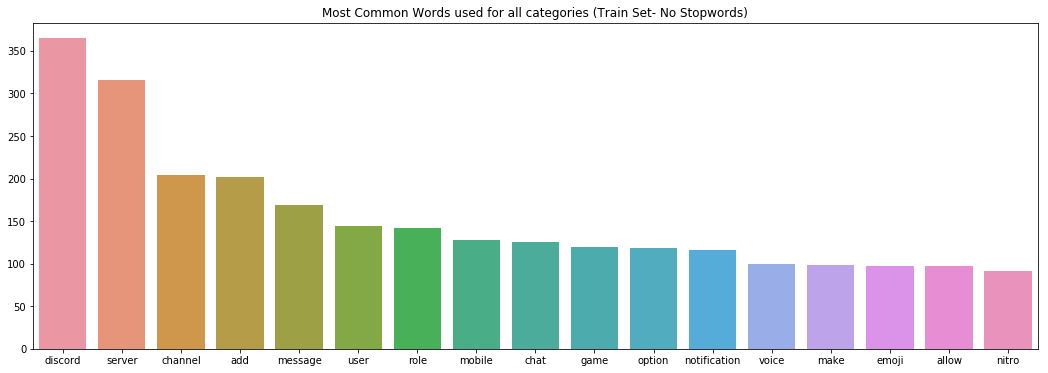

In [70]:
# Plot most common words from train set

train_common_words = [word[0] for word in trainf_c.most_common(17)]
train_common_counts = [word[1] for word in trainf_c.most_common(17)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=train_common_words, y=train_common_counts)
plt.title('Most Common Words used for all categories (Train Set- No Stopwords)')
plt.show()

In [71]:
#Extract clean corpus (test dataset) 
tclean = np.array(test['clean descr'])
tclean

array(['update the description of the manage role   server wide permission',
       'netflixdiscord', 'balk delete message   with out ban', ...,
       'role editing change',
       'late os x update cause serious performance degradation',
       'more blocking feature private account option'], dtype=object)

In [72]:
#Remove stopwords from test set
test_norm_no = norm_stop(tclean, words_removal= True)
test_norm_no

['update description manage role server wide permission',
 'netflixdiscord',
 'balk delete message ban',
 'session manager',
 'private channel icon unclear',
 'add hide switch game detection service',
 'move channel',
 'muting ping include role ping',
 'add option mobile user buy nitro set tab',
 'canbepurged role permission',
 'make role creation easier add preset duplicate option',
 'display portrait mode device upsidedown',
 'custom personal theme',
 'copy message create archive',
 'gif autoplay default',
 'text wrap role name',
 'rss feed',
 'stick solve captcha',
 'add keyboard shortcut gif picker',
 'share authorship post',
 'stop screen sharing',
 'ability remove someone profile picture serverwide',
 'big tall size',
 'create server account sync twitch suggestion',
 'incorrect display icon list window app',
 'hide nsfw text chat streamer mode',
 'stream',
 'new feature request raise hand icon button clan meeting',
 'mit grammatik hab ihr es nicht',
 'rich text edit markdown',
 '

In [73]:
#Break sentences into words
wordstest = [word for sentence in test_norm_no for word in sentence.split()]
Feed_test = Counter(wordstest)
print(Feed_test)

Counter({'discord': 177, 'server': 142, 'channel': 114, 'add': 109, 'message': 98, 'chat': 82, 'role': 74, 'user': 71, 'option': 69, 'mobile': 65, 'feature': 55, 'make': 54, 'game': 52, 'voice': 51, 'new': 46, 'nitro': 42, 'ability': 41, 'allow': 40, 'change': 38, 'emoji': 38, 'notification': 36, 'permission': 35, 'button': 35, 'custom': 33, 'text': 33, 'account': 33, 'list': 33, 'suggestion': 32, 'name': 30, 'app': 30, 'spoiler': 29, 'friend': 29, 'support': 28, 'link': 28, 'profile': 27, 'block': 27, 'delete': 26, 'hide': 26, 'mention': 26, 'member': 25, 'people': 25, 'screen': 24, 'image': 24, 'specific': 24, 'call': 24, 'bot': 23, 'group': 23, 'disable': 23, 'tag': 23, 'show': 22, 'search': 22, 'dm': 21, 'embed': 21, 'icon': 20, 'request': 20, 'see': 20, 'mode': 19, 'gif': 19, 'color': 19, 'ios': 19, 'video': 19, 'ban': 18, 'share': 18, 'android': 18, 'time': 18, 'use': 18, 'emote': 18, 'update': 17, 'tab': 17, 'someone': 17, 'window': 17, 'edit': 17, 'audio': 17, 'able': 17, 'plea

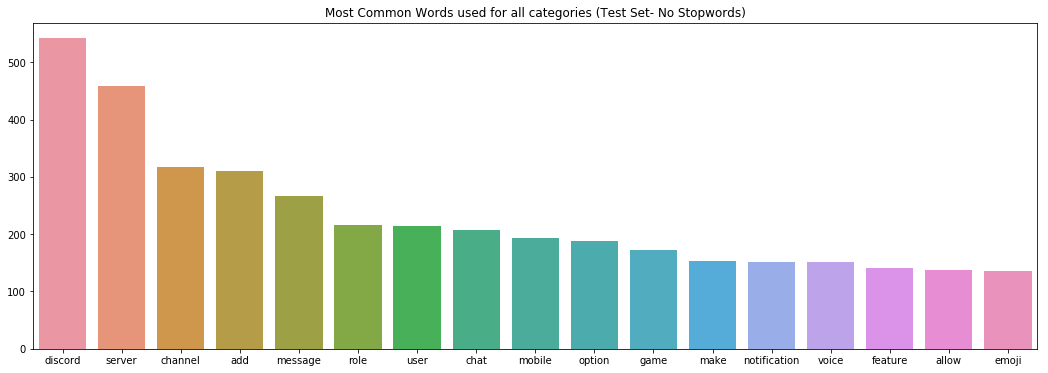

In [74]:
Feed_common_test = [word[0] for word in Feed_all.most_common(17)]
Feed_test_counts = [word[1] for word in Feed_all.most_common(17)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=Feed_common_test, y=Feed_test_counts)
plt.title('Most Common Words used for all categories (Test Set- No Stopwords)')
plt.show()

## Scenario 1 Feature Engineering 

### BOW Model: train/test with no stopwords

In [76]:
# Using the normalized train corpus to build BOW (default model)
cv = CountVectorizer(binary=False, min_df=1, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_norm_no)

# transform normalized test corpus to build BOW
cv_test_features = cv.transform(test_norm_no)

In [77]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (3032, 10872)  Test features shape: (1494, 10872)


In [78]:
bowlabels= cv.get_feature_names()

In [79]:
print(type(cv_train_features))

<class 'scipy.sparse.csr.csr_matrix'>


In [80]:
# convert the vectors obtained (train features) to a dataframe
df = pd.DataFrame(cv_train_features.toarray(), columns=bowlabels)
# Inspect dataframe to confirm vector representation of text
df

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Add votes column from train dataset to dataframe using 'values' method 
#Count vectorizer lost the index. It is best to use 'values' method
df['votes'] = train['votes'].values
df.shape

(3032, 10873)

In [82]:
# Ensure "votes" column was added and assigned correctly
df.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12


In [83]:
# Perform descriptive statistics on votes values
df.votes.describe()

count     3032.000000
mean        25.172823
std        437.852567
min        -42.000000
25%          0.000000
50%          4.000000
75%         12.000000
max      20498.000000
Name: votes, dtype: float64

In [84]:
# Include 'categories' column using 'values' method from train dataset
df['categories'] = train['categories'].values
df.head()


,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes,categories
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,Game Store
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,Other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,Chat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Chat
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,Account Server Mgmt


In [85]:
print('Vote for this feedback:', df['votes'].iloc[1])
print('Category for feedback:', df['categories'].iloc[1])

Vote for this feedback: 8
Category for feedback: Other


In [86]:
# Create Train Label variable (BOW)
label= df['categories']
label.shape

(3032,)

In [87]:
# First 5 observations from Label variable
label.head()

0             Game Store
1                  Other
2                   Chat
3                   Chat
4    Account Server Mgmt
Name: categories, dtype: object

In [88]:
# Create Train Features variable
features = df.drop(columns=['categories'])
features.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12


In [89]:
features.shape

(3032, 10873)

In [90]:
# Convert the vectors, test features, obtained to a dataframe
df1 = pd.DataFrame(cv_test_features.toarray(), columns=bowlabels)
# Inspect dataframe to confirm vector representation of text
df1.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Display top records from votes column (test dataset)
test['votes'].head()

2452     9
1941     1
971      0
2396    49
4169    -7
Name: votes, dtype: int64

In [92]:
# Display top records belonging to categories from test dataset 
test['categories'].head()

2452    Account Server Mgmt
1941                  Other
971                    Chat
2396    Account Server Mgmt
4169                   Chat
Name: categories, dtype: object

In [93]:
# Include 'votes' column using 'values' method from test dataset
df1['votes'] = test['votes'].values

# Display top records to check votes values were added
df1.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7


In [94]:
# Check number of all features observations (test dataset)
df1.shape

(1494, 10873)

In [95]:
# Include 'categories' column using 'values' method from test dataset
df1['categories'] = test['categories'].values
# Validate votes values were added as expected
df1.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes,categories
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,Account Server Mgmt
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49,Account Server Mgmt
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-7,Chat


In [96]:
# Create a label dataframe using categories. 
labelt= df1['categories']
# Check number of label observations belonging to testing data
labelt.shape

(1494,)

In [97]:
# Create Testing Features (BOW)
featurest = df1.drop(columns=['categories'])
# Inspect observations
featurest.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7


## Scenario 1: Modeling using Supervised Learning Models & Using multi-class metrics for model evaluation

### BOW Model (No stopwords)

In [98]:
# Scenario 1: No Stopwords/BoW
from sklearn.linear_model import LogisticRegression

# Initalize Logistic Regression
logregr = LogisticRegression(multi_class= 'multinomial', solver = 'lbfgs')

# Train Model
logregr.fit(features, label)

# Test Model
y_pred = logregr.predict(featurest)

In [99]:
# Evaluate Logistic Regression model performance via classification_report
print(classification_report(labelt, y_pred))

                     precision    recall  f1-score   support

                API       0.00      0.00      0.00        92
Account Server Mgmt       0.29      0.85      0.43       334
               Chat       0.64      0.34      0.44       403
         Game Store       0.00      0.00      0.00        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.00      0.00      0.00       123
              Other       0.47      0.32      0.38       443
            Overlay       0.00      0.00      0.00        36

        avg / total       0.38      0.38      0.33      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
# Calculate the confusion matrix for the Logistic Regression Model
from sklearn.metrics import confusion_matrix
bowlog = confusion_matrix(labelt, y_pred)
print(bowlog)

[[  0  62  12   0   0   0  18   0]
 [  0 284  20   0   0   0  30   0]
 [  0 217 137   0   0   0  49   0]
 [  0  29   1   0   0   0  26   0]
 [  0   5   0   0   0   0   2   0]
 [  0  89   8   0   0   0  26   0]
 [  0 272  31   0   0   0 140   0]
 [  0  25   5   0   0   0   6   0]]


Text(0.5, 257.44, 'Predicted label')

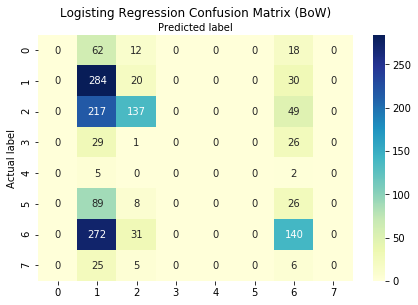

In [101]:
class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(bowlog), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Logisting Regression Confusion Matrix (BoW)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [102]:
# Initalize Random Forest 
from sklearn.ensemble import RandomForestClassifier

rfcw = RandomForestClassifier(n_estimators=100)

# Train 
rfcw.fit(features, label)

# Predict 

ypredbow=rfcw.predict(featurest)

In [103]:
# Evaluate Random Forest model performance via classification_report
print(classification_report(labelt, ypredbow))

                     precision    recall  f1-score   support

                API       0.19      0.15      0.17        92
Account Server Mgmt       0.56      0.53      0.54       334
               Chat       0.54      0.62      0.58       403
         Game Store       0.66      0.55      0.60        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.67      0.49      0.56       123
              Other       0.47      0.51      0.49       443
            Overlay       0.57      0.36      0.44        36

        avg / total       0.51      0.51      0.51      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
# Calculate the confusion matrix for Random Forest Model
bowrfc = confusion_matrix(labelt, ypredbow)
print(bowrfc)

[[ 14   9  30   2   0   4  31   2]
 [ 11 176  59   1   0   3  82   2]
 [ 16  39 249   1   0  13  85   0]
 [  0   1   4  31   0   1  19   0]
 [  3   0   1   1   0   0   2   0]
 [  1  12  18   1   0  60  31   0]
 [ 29  75  88  10   0   9 226   6]
 [  0   2  11   0   0   0  10  13]]


Text(0.5, 257.44, 'Predicted label')

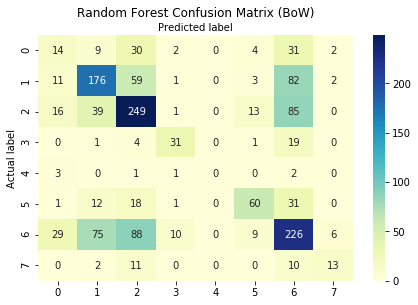

In [105]:
class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(bowrfc), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion Matrix (BoW)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [106]:
# Initialize Gradient Boosting (BoW) - Default model 

from sklearn.ensemble import GradientBoostingClassifier

clbow = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clbow.fit(features, label)

# Predict
ypredgb = clbow.predict(featurest)

In [107]:
# Evaluate Gradient Boosting model performance via classification_report
print(classification_report(labelt, ypredgb))

                     precision    recall  f1-score   support

                API       0.15      0.05      0.08        92
Account Server Mgmt       0.55      0.46      0.50       334
               Chat       0.53      0.55      0.54       403
         Game Store       0.67      0.52      0.59        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.60      0.57      0.59       123
              Other       0.45      0.59      0.51       443
            Overlay       0.56      0.42      0.48        36

        avg / total       0.50      0.51      0.50      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [108]:
# Calculate the confusion matrix for Gradient Boosting
bowrgbb = confusion_matrix(labelt, ypredgb)
print(bowrgbb)

[[  5   7  29   1   0   6  42   2]
 [  9 154  55   2   0  10 102   2]
 [  5  39 220   1   0  18 116   4]
 [  0   2   4  29   0   2  19   0]
 [  0   0   4   0   0   0   3   0]
 [  0  10  14   1   0  70  27   1]
 [ 15  64  80   9   0  10 262   3]
 [  0   4   8   0   0   0   9  15]]


Text(0.5, 257.44, 'Predicted label')

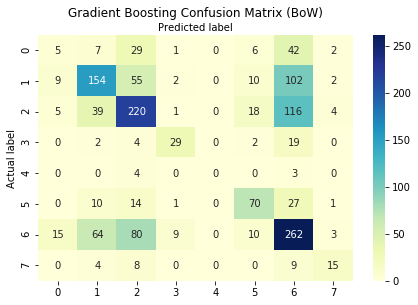

In [109]:
class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(bowrgbb), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Gradient Boosting Confusion Matrix (BoW)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### TF-IDF Model ( dataset with no stopwords)

In [110]:
# Build TFIDF features on train reviews. Changed the min_df = 0.00 to .005 (3/15)
tv = TfidfVectorizer(use_idf=True, min_df=1, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_norm_no)

# transform test reviews into features
tv_test_features = tv.transform(test_norm_no)

In [111]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (3032, 10872)  Test features shape: (1494, 10872)


In [112]:
names = tv.get_feature_names()

In [113]:
# Convert the vectors obtained (train features) to an array and assign it to a dataframe
df2 = pd.DataFrame(tv_train_features.toarray(), columns = names)
# Inspect dataframe to confirm vector representation of text
df2.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# Use 'values' method to add corresponding votes (train dataset) to dataframe (TF-IDF)
df2['votes'] = train['votes'].values
# Check that votes column is added
df2.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [115]:
# Use 'values' method to add corresponding categories (train dataset) to dataframe (TF-IDF)
df2['categories'] = train['categories'].values
# Inspect that categories column is added 
df2.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Game Store
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Chat
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Chat
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,Account Server Mgmt


In [116]:
# Create training Label (TF-IDF model) from dataframe
trainlabel= df2['categories']
# Check shape is as expected  
trainlabel.shape

(3032,)

In [117]:
# Create Training Features (TF-IDF model)
trngfeatures = df2.drop(columns=['categories'])
# Inspect it contains the expected features
trngfeatures.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [119]:
trngfeatures.shape

(3032, 10873)

In [120]:
# Create dataframe for test features array (TF-IDF model) 
df3 = pd.DataFrame(tv_test_features.toarray(), columns = names)
# Inspect dataframe to confirm vector representation of text
df3.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
##Use 'values' method to add corresponding votes observations (test dataset) to dataframe (TF-IDF BOW)
df3['votes'] = test['votes'].values
df3.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7


In [122]:
# Use 'values' method to add corresponding categories (test dataset) to dataframe (TF-IDF BOW)
df3['categories'] = test['categories'].values
df3.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,Account Server Mgmt
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Chat
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,Account Server Mgmt
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7,Chat


In [123]:
# Create test Label (TF-IDF model)
testlabel = df3['categories']
# Confirm test label shape is as expected
testlabel.shape

(1494,)

In [124]:
#Create test Features (TF-IDF model)
testfeatures = df3.drop(columns=['categories'])
# Confirm features include all selected columns
testfeatures.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zbyciu kod,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7


## Scenario 1: Modeling using Supervised Learning Models (TF-IDF method) & Using multi-class metrics for model evaluation

In [125]:
# Initalize Logistic Regression for TF-IDF (no stopwords)
logregr = LogisticRegression(multi_class= 'multinomial', solver = 'lbfgs')

# Train Model
logregr.fit(trngfeatures, trainlabel)

# Test Model
y_pred = logregr.predict(testfeatures)

In [126]:
# Calculate classification report for Logistic Regression
print(classification_report(testlabel, y_pred))

                     precision    recall  f1-score   support

                API       0.00      0.00      0.00        92
Account Server Mgmt       0.29      0.52      0.37       334
               Chat       0.60      0.21      0.31       403
         Game Store       0.00      0.00      0.00        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.00      0.00      0.00       123
              Other       0.37      0.62      0.46       443
            Overlay       0.00      0.00      0.00        36

        avg / total       0.34      0.36      0.30      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [127]:
# Calculate confusion matrix for Logistic Regression
tfilog_matrix = confusion_matrix(testlabel, y_pred)
tfilog_matrix

array([[  0,  41,  12,   0,   0,   0,  39,   0],
       [  0, 174,  11,   0,   0,   0, 149,   0],
       [  0, 137,  85,   0,   0,   0, 181,   0],
       [  0,  27,   0,   0,   0,   0,  29,   0],
       [  0,   6,   0,   0,   0,   0,   1,   0],
       [  0,  60,   7,   0,   0,   0,  56,   0],
       [  0, 145,  24,   0,   0,   0, 274,   0],
       [  0,  17,   2,   0,   0,   0,  17,   0]])

Text(0.5, 257.44, 'Predicted label')

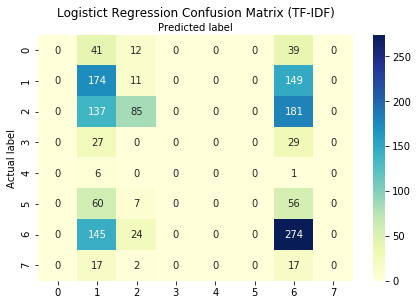

In [128]:
class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(tfilog_matrix ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Logistict Regression Confusion Matrix (TF-IDF)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [129]:
# Initalize Random Forest (TF-IDF)
from sklearn.ensemble import RandomForestClassifier

rfc1=RandomForestClassifier(n_estimators=100)

# Train 
rfc1.fit(trngfeatures, trainlabel)

# Predict 

ypredr=rfc1.predict(testfeatures)

In [130]:
#Random Forest classification report
print(classification_report(testlabel, ypredr))

                     precision    recall  f1-score   support

                API       0.27      0.18      0.22        92
Account Server Mgmt       0.54      0.55      0.54       334
               Chat       0.53      0.65      0.58       403
         Game Store       0.70      0.59      0.64        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.70      0.50      0.58       123
              Other       0.49      0.50      0.49       443
            Overlay       0.92      0.33      0.49        36

        avg / total       0.53      0.53      0.52      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
# Calculate confusion matrix for Random Forest
con_matrix = confusion_matrix(testlabel, ypredr)
con_matrix

array([[ 17,  13,  29,   1,   0,   3,  29,   0],
       [  8, 184,  58,   1,   0,   3,  80,   0],
       [ 13,  42, 261,   1,   0,  13,  73,   0],
       [  1,   2,   3,  33,   0,   2,  15,   0],
       [  2,   1,   3,   0,   0,   0,   1,   0],
       [  2,  14,  21,   1,   0,  61,  24,   0],
       [ 19,  83, 105,  10,   0,   5, 220,   1],
       [  0,   3,  11,   0,   0,   0,  10,  12]])

Text(0.5, 257.44, 'Predicted label')

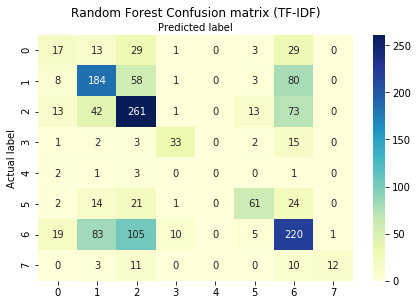

In [132]:

class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(con_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix (TF-IDF)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [133]:
rftop = pd.DataFrame(rfc1.feature_importances_, index = trngfeatures.columns, columns = ['importance']).sort_values('importance', ascending=False)
rftop

,importance
votes,0.033763
mobile,0.016295
server,0.014396
discord,0.010756
nitro,0.010514
role,0.010329
overlay,0.008992
message,0.007947
channel,0.006386
chat,0.006354


In [135]:
# Initialize Gradient Boosting (TF-IDF) - Default model 

from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clf1.fit(trngfeatures, trainlabel)

# Predict
ypredg = clf1.predict(testfeatures)



In [136]:
# Gradient boosting classification report
print(classification_report(testlabel, ypredg))

                     precision    recall  f1-score   support

                API       0.15      0.14      0.15        92
Account Server Mgmt       0.48      0.46      0.47       334
               Chat       0.49      0.48      0.48       403
         Game Store       0.56      0.59      0.57        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.57      0.54      0.56       123
              Other       0.44      0.46      0.45       443
            Overlay       0.31      0.44      0.36        36

        avg / total       0.45      0.45      0.45      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
# Calculate confusion matrix for Gradient Boosting
gcon_matrix = confusion_matrix(testlabel, ypredg)
gcon_matrix

array([[ 13,   8,  31,   1,   0,   4,  30,   5],
       [  9, 154,  64,   1,   0,   9,  89,   8],
       [ 16,  61, 193,   4,   0,  22,  99,   8],
       [  2,   1,   4,  33,   0,   2,  14,   0],
       [  2,   0,   2,   1,   0,   0,   2,   0],
       [  4,  10,  17,   2,   0,  67,  21,   2],
       [ 38,  82,  77,  16,   0,  14, 203,  13],
       [  0,   5,   7,   1,   0,   0,   7,  16]])

Text(0.5, 257.44, 'Predicted label')

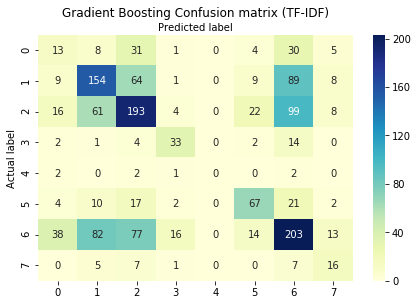

In [138]:
class_names=[0,8] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(gcon_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Gradient Boosting Confusion matrix (TF-IDF)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Hyperparameter tuning (No stopwords)

In [139]:
# Initalize Random Forest (TF-IDF)- Hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

rfctuning=RandomForestClassifier(n_estimators=150, criterion ='entropy')

# Train 
rfctuning.fit(trngfeatures, trainlabel)

# Predict 

ypredt=rfctuning.predict(testfeatures)

In [140]:
#Random Forest classification report- Hyperparameter tuning
print(classification_report(testlabel, ypredt))

                     precision    recall  f1-score   support

                API       0.33      0.14      0.20        92
Account Server Mgmt       0.54      0.54      0.54       334
               Chat       0.53      0.63      0.58       403
         Game Store       0.71      0.57      0.63        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.67      0.49      0.56       123
              Other       0.48      0.53      0.50       443
            Overlay       0.76      0.36      0.49        36

        avg / total       0.53      0.53      0.52      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Scenario 2: Not Removing stopwords 

In [141]:
#Extract clean corpus (train dataset)
cleantf = np.array(train['clean descr'])
cleantf.shape

(3032,)

In [142]:
#Extract clean corpus (test dataset)
cleantest = np.array(test['clean descr'])
cleantest.shape

(1494,)

In [144]:
# Using the normalized train corpus to build BoW (default model)
cvs = CountVectorizer(binary=False, min_df=1, max_df=1.0, ngram_range=(1,2))
cvs_train_features = cvs.fit_transform(cleantf)

# transform normalized test corpus to build BOW
cvs_test_features = cvs.transform(cleantest)

In [145]:
print('BoW model:> Train features shape:', cvs_train_features.shape, ' Test features shape:', cvs_test_features.shape)

BoW model:> Train features shape: (3032, 13002)  Test features shape: (1494, 13002)


In [146]:
stlabels = cvs.get_feature_names()

In [147]:
dfw = pd.DataFrame(cvs_train_features.toarray(), columns=stlabels)
dfw.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
dfw.shape

(3032, 13002)

In [149]:
dfw['votes'] = train['votes'].values
dfw.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12


In [150]:
dfw['categories'] = train['categories'].values
dfw.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes,categories
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,Game Store
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,Other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,Chat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Chat
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,Account Server Mgmt


In [151]:
# Create Train Label variable (BOo)
labelw= dfw['categories']
labelw.shape

(3032,)

In [152]:
# Crate Train Features- BoW
featuresw = dfw.drop(columns=['categories'])
featuresw.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12


In [153]:
featuresw.shape

(3032, 13003)

In [154]:
dfw1 = pd.DataFrame(cvs_test_features.toarray())
dfw1.head()

,0,1,2,3,4,5,6,7,8,9,...,12992,12993,12994,12995,12996,12997,12998,12999,13000,13001
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
# Add votes column to dataframe
dfw1['votes'] = test['votes'].values
dfw1.head()

,0,1,2,3,4,5,6,7,8,9,...,12993,12994,12995,12996,12997,12998,12999,13000,13001,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7


In [156]:
# Add categories column to dataframe
dfw1['categories'] = test['categories'].values
dfw1.head()

,0,1,2,3,4,5,6,7,8,9,...,12994,12995,12996,12997,12998,12999,13000,13001,votes,categories
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,Account Server Mgmt
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49,Account Server Mgmt
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-7,Chat


In [157]:
# Create Test Label variable (BoW)
labelw1= dfw1['categories']
labelw1.shape

(1494,)

In [158]:
# Crate Test Features- BoW
featuresw1 = dfw1.drop(columns=['categories'])
featuresw1.head()

,0,1,2,3,4,5,6,7,8,9,...,12993,12994,12995,12996,12997,12998,12999,13000,13001,votes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7


In [159]:
featuresw1.shape

(1494, 13003)

## Scenario 2: Modeling and Performance Review (stopwords)

In [160]:
# Initalize Random Forest (BoW with stopwords)
from sklearn.ensemble import RandomForestClassifier

rfc1=RandomForestClassifier(n_estimators=100)

# Train 
rfc1.fit(featuresw, labelw)

# Predict 

ypredr=rfc1.predict(featuresw1)

In [161]:
#Random Forest classification report
print(classification_report(labelw1, ypredr))

                     precision    recall  f1-score   support

                API       0.28      0.09      0.13        92
Account Server Mgmt       0.54      0.52      0.53       334
               Chat       0.53      0.66      0.59       403
         Game Store       0.72      0.59      0.65        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.69      0.54      0.61       123
              Other       0.49      0.53      0.51       443
            Overlay       0.76      0.36      0.49        36

        avg / total       0.53      0.53      0.52      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [162]:
# Calculate confusion matrix for Random Forest 
conbow_matrix = confusion_matrix(labelw1, ypredr)
conbow_matrix

array([[  8,  12,  32,   1,   0,   4,  35,   0],
       [  6, 173,  70,   2,   0,   2,  81,   0],
       [  2,  41, 265,   1,   0,  13,  81,   0],
       [  0,   1,   4,  33,   0,   2,  16,   0],
       [  0,   0,   4,   0,   0,   0,   3,   0],
       [  1,  11,  19,   0,   0,  66,  25,   1],
       [ 12,  79,  95,   9,   0,   8, 237,   3],
       [  0,   2,  12,   0,   0,   0,   9,  13]])

Text(0.5, 257.44, 'Predicted label')

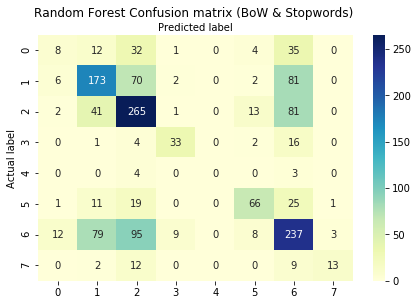

In [163]:
class_names=[0,7] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conbow_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix (BoW & Stopwords) ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Scenario 2: TF-IDF Model (train/test with stopwords)

In [164]:
# Run TIDF model on train/test datasets
tvs = TfidfVectorizer(use_idf=True, min_df=1, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tvs_train_features = tvs.fit_transform(cleantf)

# transform test reviews into features
tvs_test_features = tvs.transform(cleantest)

In [165]:
print('TF-IDF model:> Train features shape:', tvs_train_features.shape, ' Test features shape:', tvs_test_features.shape)

TF-IDF model:> Train features shape: (3032, 13002)  Test features shape: (1494, 13002)


In [166]:
stf_labels= tvs.get_feature_names()

In [167]:
dfw2 = pd.DataFrame(tvs_train_features.toarray(), columns= stf_labels)
dfw2.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
# Add votes column to dataframe
dfw2['votes'] = train['votes'].values
dfw2.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [169]:
# Add categories column to dataframe
dfw2['categories'] = train['categories'].values
dfw2.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Game Store
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Chat
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Chat
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,Account Server Mgmt


In [170]:
# Create Train Label variable (TF-IDF)
labelti= dfw2['categories']
labelti.shape

(3032,)

In [171]:
# Crate Train Features (TF-IDF)
featuresti = dfw2.drop(columns=['categories'])
featuresti.head()

,0001,0001 or,008,008 for,10,10 desktop,10 keep,10 member,10 minute,10 my,...,zbyciu kod,zone,zone when,zoom,zoom on,zooma,zooma ut,zoomade,zoomade in,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [172]:
dfw3 = pd.DataFrame(tvs_test_features.toarray())
dfw3.head()

,0,1,2,3,4,5,6,7,8,9,...,12992,12993,12994,12995,12996,12997,12998,12999,13000,13001
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
# Add categories column to dataframe
dfw3['categories'] = test['categories'].values
dfw3.head()

,0,1,2,3,4,5,6,7,8,9,...,12993,12994,12995,12996,12997,12998,12999,13000,13001,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Server Mgmt
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chat
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Server Mgmt
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chat


In [174]:
# Add votes column to dataframe
dfw3['votes'] = test['votes'].values
dfw3.head()

,0,1,2,3,4,5,6,7,8,9,...,12994,12995,12996,12997,12998,12999,13000,13001,categories,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Server Mgmt,9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chat,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Account Server Mgmt,49
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chat,-7


In [175]:
# Create Test Label variable (TF-IDF)
labelti1= dfw3['categories']
labelti1.shape

(1494,)

In [176]:
# Crate Test Features (TF-IDF)
featuresti1 = dfw3.drop(columns=['categories'])
featuresti1.head()

,0,1,2,3,4,5,6,7,8,9,...,12993,12994,12995,12996,12997,12998,12999,13000,13001,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7


## Modeling and Performance Review- Random Forest (TF-IDF)

In [177]:
# Initalize Random Forest (Tfidf with stopwords)
from sklearn.ensemble import RandomForestClassifier

rfc1=RandomForestClassifier(n_estimators=100)

# Train 
rfc1.fit(featuresti, labelti)

# Predict 

ypredri=rfc1.predict(featuresti1)

In [178]:
#Random Forest classification report
print(classification_report(labelti1, ypredri))

                     precision    recall  f1-score   support

                API       0.35      0.12      0.18        92
Account Server Mgmt       0.54      0.53      0.54       334
               Chat       0.52      0.68      0.59       403
         Game Store       0.68      0.57      0.62        56
        Merchandise       0.00      0.00      0.00         7
             Mobile       0.68      0.53      0.60       123
              Other       0.49      0.50      0.50       443
            Overlay       0.93      0.36      0.52        36

        avg / total       0.53      0.53      0.52      1494



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [179]:
# Calculate confusion matrix for Random Forest 
conti_matrix = confusion_matrix(labelti1, ypredri)
conti_matrix

array([[ 11,   9,  36,   1,   0,   5,  30,   0],
       [  3, 177,  66,   1,   0,   3,  84,   0],
       [  5,  39, 273,   1,   0,  14,  71,   0],
       [  1,   2,   6,  32,   0,   2,  13,   0],
       [  0,   1,   2,   1,   0,   1,   2,   0],
       [  1,  10,  23,   1,   0,  65,  23,   0],
       [ 10,  87, 107,  10,   0,   5, 223,   1],
       [  0,   2,  10,   0,   0,   0,  11,  13]])

Text(0.5, 257.44, 'Predicted label')

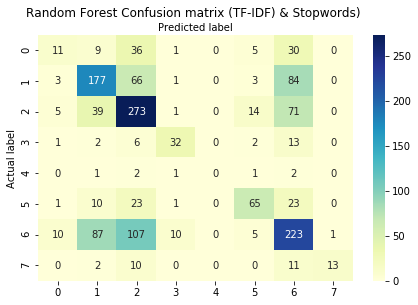

In [180]:
class_names=[0,7] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conti_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix (TF-IDF) & Stopwords) ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Improving model performance
### Removing Merchandise Category

In [181]:
# Dataset with stopword
ndiscord.loc[ndiscord['categories'] == 'Merchandise']

,clean descr,votes,categories
3750,wumpus plusie,5,Merchandise
3751,merch should be giftable through discord chat ...,26,Merchandise
3752,merch for verified server ownersteam,11,Merchandise
3754,will discord be sell pin on their website,15,Merchandise
3755,stream,15,Merchandise
3756,wumpus item,110,Merchandise
3757,onesie,15,Merchandise
3758,discord bandanna,16,Merchandise
3759,discord hoodie variety and idea,12,Merchandise
3760,ember mug,9,Merchandise


In [182]:
# Remove Merchandise label and associated observations
odiscord = ndiscord.drop(ndiscord[ndiscord.categories == 'Merchandise'].index)
odiscord.shape

(4508, 3)

In [183]:
# Validate that no Merchandise observations remain
odiscord.loc[odiscord['categories'] == 'Merchandise']

,clean descr,votes,categories


In [184]:
# Create Test/Train datasets from odiscord dataframe
ptrain, ptest = train_test_split(odiscord, test_size=0.33, random_state=42)
print('Feedback short desc:', ptrain['clean descr'].iloc[17])
print('Vote for this feedback:', ptrain['votes'].iloc[17])
print('Category for feedback:', ptrain['categories'].iloc[17])
print('Training Data Shape:', ptrain.shape)
print('Testing Data Shape:', ptest.shape)

Feedback short desc: add original poster i would and deleter i would on message_delete dataset
Vote for this feedback: 4
Category for feedback: API
Training Data Shape: (3020, 3)
Testing Data Shape: (1488, 3)


In [185]:
# Create an array for text observations (train dataset)
pclean = np.array(ptrain['clean descr'])
pclean

array(['ui suggestion', 'allow nitro user to change client side sound',
       'background discord controlling', ...,
       'notification mute improvement',
       'option to disable gif emoji on a serverbasis',
       'user with too many role can not have his profile fully display'],
      dtype=object)

In [186]:
# Remove stopwords from text data array (train)
ptrain_norm_no = norm_stop(pclean, words_removal= True)
# Inspect Normalized corpues
ptrain_norm_no

['ui suggestion',
 'allow nitro user change client side sound',
 'background discord controlling',
 'swipe right left edge screen go back',
 'arabic language',
 'hide bot member list',
 'dnd mode',
 'option server owner allow member choose list server thumbnail discord app',
 'move everyone role list',
 'add option autodecline friend request specific server',
 'game mod support discord',
 'customizable discord',
 'moderation option',
 'change voice activity icon match discord icon style',
 'suggestion discord platform general',
 'gdm member',
 'ability track message view',
 'add original poster would deleter would message_delete dataset',
 'discord add nitro change discord tag c4 like csgo normal emoji also second discord tag use someone try add',
 'make chat emoji bigger pretty please',
 'hackearam minha conta e desativaram ela',
 'streaming channel',
 'add payment option discord nitro',
 'add file support ios',
 'allow user pick quality screenshare web version',
 'see screen video sh

In [187]:
# Make clean descr or text data (test dataset) into an array
cleantp = np.array(ptest['clean descr'])
cleantp

array(['channel merging', 'create or get referral link',
       'ios muteunmute channel', ...,
       'option to auto mute new text channel',
       'new permission assign role', 'member list minimization'],
      dtype=object)

In [188]:
# Remove stopwords from text data array (test dataset)
ptest_norm_no = norm_stop(cleantp, words_removal= True)
# Inspect Normalized corpus
ptest_norm_no

['channel merging',
 'create get referral link',
 'ios muteunmute channel',
 'pin dm someone top dm list',
 'dlc directly discord store',
 'problema con le cuffie',
 'granular channel management permission',
 'discord server search bar',
 'text command',
 'multiple account mishap',
 'build music player',
 'idea multitasker',
 'bluetooth disconnect issue',
 'p2p call instead server',
 'medium verification level must become customizeable',
 'role tag mod exclusive',
 'suggestion super pinned message message super epingle',
 'black box system retreive delete channel content',
 'linux desktop app start tray without create application window',
 'custom keyboard shortcutskeybind',
 'organize emote picker',
 'roleplay friendly text chat remove character limit option',
 'wide range connection',
 'revalidate discord login access select payment type dialog',
 'date erotic server',
 'password problem',
 'auto reveal spoiler option',
 'channel join date',
 'way check long someone use server total 

In [189]:
# Run TIDF model on train/test datasets
tv7 = TfidfVectorizer(use_idf=True, min_df=1, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv7_train_features = tv7.fit_transform(ptrain_norm_no)

# transform test reviews into features
tv7_test_features = tv7.transform(ptest_norm_no)

In [190]:
print('TFIDF model:> Train features shape:', tv7_train_features.shape, ' Test features shape:', tv7_test_features.shape)

TFIDF model:> Train features shape: (3020, 10857)  Test features shape: (1488, 10857)


In [193]:
labels7 = tv7.get_feature_names()

In [194]:
# Convert the vectors obtained (train features) to an array and assign it to a dataframe
df4 = pd.DataFrame(tv7_train_features.toarray(), columns= labels7)
# Inspect dataframe to confirm vector representation of text data
df4.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# Check shape of train dataset 
df4.shape

(3020, 10857)

In [196]:
# Use 'values' method to include votes observations to dataframe 
df4['votes'] = ptrain['votes'].values
# Inspect that vote column is there
df4.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [197]:
# Use 'values' method to include categories observations to dataframe 
df4['categories'] = ptrain['categories'].values
# Check Categories column is there
df4.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Other
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,Game Store
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,API
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11,Mobile
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,Other


In [198]:
# Create Label variable (train dataset) - TFIDF model
tplabel= df4['categories']
tplabel.shape

(3020,)

In [199]:
# Create Features variable (train dataset)- TFIDF model
tpfeatures = df4.drop(columns=['categories'])
tpfeatures.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [200]:
# Confirm feature shape is as expected
tpfeatures.shape

(3020, 10858)

In [203]:
# Convert the vectors obtained (test dataset) to an array and assign it to a dataframe
dff = pd.DataFrame(tv7_test_features.toarray(), columns= labels7)
# Check shape is as expected
dff.shape

(1488, 10857)

In [204]:
# Use 'values' method to add votes observations
dff['votes'] = ptest['votes'].values
# Confirm votes colum has been added
dff.tail()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes
1483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15


In [205]:
# Confirm votes column has been added (Test dataset)
dff.shape

(1488, 10858)

In [206]:
# Use 'values' method to add categories column
dff['categories'] = ptest['categories'].values
dff.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,Chat
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,Mobile
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70,Chat
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10,Game Store


In [207]:
# Create features variable (TFIDF model)
features7 = dff.drop(columns=['categories'])
features7.head()

,0001,0001 6383,008,008 linux,10,10 15,10 desktop,10 keep,10 member,10 minute,...,zone spam,zoom,zoom mobile,zooma,zooma ut,zoomade,zoomade nu,zoophilia,zoophilia tos,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10


In [208]:
# Create label variable (TFIDF model)
label7= dff['categories']
label7.head()

0          Chat
1         Other
2        Mobile
3          Chat
4    Game Store
Name: categories, dtype: object

## Modeling and Performance Review- Random Forest (TF-IDF)

In [209]:
# Initialize Random Forest model 

rfcp=RandomForestClassifier(n_estimators=100)

# Train 
rfcp.fit(tpfeatures, tplabel)

# Predict 

yppredr7= rfcp.predict(features7)

In [210]:
# Calculate classification report for Random Forest 
print(classification_report(label7, yppredr7))

                     precision    recall  f1-score   support

                API       0.42      0.17      0.24        89
Account Server Mgmt       0.55      0.55      0.55       345
               Chat       0.57      0.64      0.60       409
         Game Store       0.73      0.57      0.64        65
             Mobile       0.70      0.52      0.60       118
              Other       0.48      0.55      0.51       431
            Overlay       0.55      0.35      0.43        31

        avg / total       0.55      0.54      0.54      1488



In [211]:
# Calculate confusion matrix for Random Forest 
con7_matrix = confusion_matrix(label7, yppredr7)
con7_matrix

array([[ 15,  12,  26,   2,   1,  33,   0],
       [  3, 189,  65,   1,   2,  82,   3],
       [  4,  43, 260,   1,  14,  87,   0],
       [  1,   4,   5,  37,   3,  15,   0],
       [  0,   7,  17,   1,  61,  30,   2],
       [ 13,  84,  79,   9,   6, 236,   4],
       [  0,   6,   5,   0,   0,   9,  11]])

Text(0.5, 257.44, 'Predicted label')

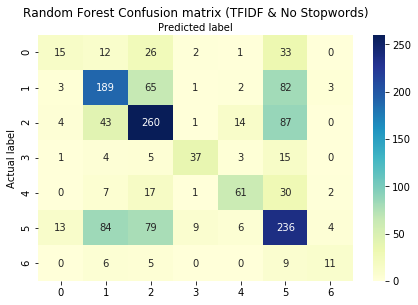

In [212]:
class_names=[0,7] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(con7_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix (TFIDF & No Stopwords)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [213]:
# Initialize Gradient Boosting- Default model 

clfp7 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clfp7.fit(tpfeatures, tplabel)

# Predict
ypredpg7 = clfp7.predict(features7)



In [214]:
# Calculate classification report for Gradient Boosting
print(classification_report(label7, ypredpg7))

                     precision    recall  f1-score   support

                API       0.33      0.01      0.02        89
Account Server Mgmt       0.12      0.06      0.07       345
               Chat       0.23      0.75      0.35       409
         Game Store       0.00      0.00      0.00        65
             Mobile       0.00      0.00      0.00       118
              Other       0.00      0.00      0.00       431
            Overlay       1.00      0.10      0.18        31

        avg / total       0.13      0.22      0.12      1488



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [215]:
# Calculate confusion matrix for Gradient Boosting
cong7_matrix = confusion_matrix(label7, ypredpg7)
cong7_matrix

array([[  1,   8,  80,   0,   0,   0,   0],
       [  0,  19, 325,   0,   0,   1,   0],
       [  0, 104, 305,   0,   0,   0,   0],
       [  0,   1,  64,   0,   0,   0,   0],
       [  0,   8, 110,   0,   0,   0,   0],
       [  2,  21, 408,   0,   0,   0,   0],
       [  0,   1,  27,   0,   0,   0,   3]])

Text(0.5, 257.44, 'Predicted label')

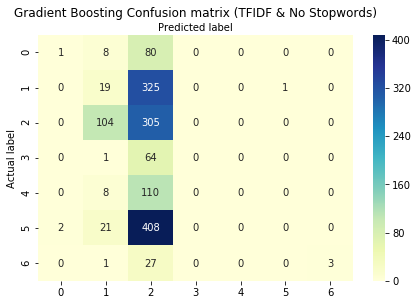

In [216]:
class_names=[0,7] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cong7_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Gradient Boosting Confusion matrix (TFIDF & No Stopwords)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Build Model for API, Account Server, Other and Chat

In [218]:
adiscord = odiscord[~(odiscord.categories =='Game Store')]
adiscord.shape

(4331, 3)

In [219]:
bdiscord = adiscord[~(adiscord.categories =='Overlay')]

In [220]:
cdiscord = bdiscord[~(bdiscord.categories =='Mobile')]

In [221]:
cdiscord['categories'].value_counts()

Chat                   1247
Other                  1228
Account Server Mgmt    1042
API                     297
Name: categories, dtype: int64

In [222]:
# Create Test/Train datasets from odiscord dataframe
trainp, testp = train_test_split(cdiscord, test_size=0.33, random_state=42)
print('Feedback short desc:', trainp['clean descr'].iloc[17])
print('Vote for this feedback:', trainp['votes'].iloc[17])
print('Category for feedback:', trainp['categories'].iloc[17])
print('Training Data Shape:', trainp.shape)
print('Testing Data Shape:', testp.shape)

Feedback short desc: youtube streaming status message
Vote for this feedback: 20
Category for feedback: Account Server Mgmt
Training Data Shape: (2555, 3)
Testing Data Shape: (1259, 3)


In [223]:
# Create an array for text observations (train dataset)
cleanp = np.array(trainp['clean descr'])
cleanp

array(['upgrade your friend nitro button should only be show in dms not in general server',
       'i can be in two call at the same time use one account',
       'add thai language please', ...,
       'user with too many role can not have his profile fully display',
       'discord seem too eager to forget scroll position after be interrupt',
       'a tab in server setting to see a summary of who   everyone and   here affect'],
      dtype=object)

In [224]:
# Remove stopwords from text data array (train dataset)
trainp_norm_no = norm_stop(cleanp, words_removal= True)
# Inspect Normalized corpus
trainp_norm_no

['upgrade friend nitro button show dms general server',
 'two call time use one account',
 'add thai language please',
 'notification dms seperate server',
 'wow addon manager',
 'permissionless role',
 'discord open steam link steam client rather browser',
 'need status message bio',
 'audio damping',
 'clone account single email address',
 'clear text chat',
 '2 server randomly disappear discord list',
 'self bot',
 'make discord ps4 please',
 'add transparent background supportdiscordappcom page',
 'editdelete message permission',
 'system point hypesquad house',
 'youtube streaming status message',
 'disable dms specific user without block',
 'typo break link',
 'subcategorie',
 'keybind kick user user would',
 'feature suggestion server category organization',
 'account disable update',
 'block user show server',
 'computer spec',
 'bot pms',
 'soundboard',
 'discord lag macbook air 2018',
 'give manage role everyone work',
 'multichat',
 'possible role mention tweak',
 'discord s

In [225]:
# Create an array for text observations (test dataset)
cleantp = np.array(testp['clean descr'])
cleantp

array(['shift delete', 'discord build number in setting',
       'spoiler be spoil my discord experience', ...,
       'personal computer touchscreen support',
       'toggtoggleable push to talk in game',
       'please add a feature that allow you to mass delete your own message'],
      dtype=object)

In [226]:
# Remove stopwords from text data array (test dataset)
testp_norm_no = norm_stop(cleantp, words_removal= True)
# Inspect Normalized corpus
testp_norm_no

['shift delete',
 'discord build number setting',
 'spoiler spoil discord experience',
 'idea update',
 'make play music easy',
 'firefox 650 endless connect login',
 'option disable autoscroll scroll',
 'sm primary 2 way auth option',
 '10 dm member limit need change',
 'link voice channel text chat',
 'exclude channel audit log',
 'chat history 1 keer wissen',
 'cool idea omg',
 'grant mention everyone permission everyone role default first create server',
 'append gif link select one',
 'management pnsdms',
 'problem call people outside country',
 'allow us turn mobile symbol next name serverwide',
 'pausingresum file upload',
 'mark server notification read',
 'spoiler tag',
 'translate discord estonian language',
 'ability respond individual message thread style stackoverflow chat',
 'ui suggestion',
 'open game directly chat',
 'role search',
 'channel topic pin message',
 'conexao',
 'create server account sync twitch suggestion',
 'soundcloud',
 'communication couple voice chan

In [227]:
# Transform text data into its vector representation
tvp4 = TfidfVectorizer(use_idf=True, min_df=0.01, max_df=1.0, ngram_range=(1,3),
                     sublinear_tf=True)
tvp4_train_features = tvp4.fit_transform(trainp_norm_no)

# transform test reviews into features
tvp4_test_features = tvp4.transform(testp_norm_no)

In [228]:
labels4= tvp4.get_feature_names()

In [229]:
dt4 = pd.DataFrame(tvp4_train_features.toarray(), columns= labels4)
dt4.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,text,update,use,user,video,voice,voice channel,way,window,would
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.454866,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.537635,0.000000,0.0,0.0,0.0,0.0,0.000000,0.603629,0.0,...,0.0,0.0,0.588712,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.563907,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
dt4['votes'] = trainp['votes'].values
dt4.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,update,use,user,video,voice,voice channel,way,window,would,votes
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.454866,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.537635,0.000000,0.0,0.0,0.0,0.0,0.000000,0.603629,0.0,...,0.0,0.588712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.000000,0.563907,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12


In [231]:
dt4['categories'] = trainp['categories'].values
dt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 83 columns):
ability          2555 non-null float64
account          2555 non-null float64
add              2555 non-null float64
allow            2555 non-null float64
app              2555 non-null float64
block            2555 non-null float64
bot              2555 non-null float64
button           2555 non-null float64
call             2555 non-null float64
category         2555 non-null float64
change           2555 non-null float64
channel          2555 non-null float64
chat             2555 non-null float64
click            2555 non-null float64
color            2555 non-null float64
connection       2555 non-null float64
custom           2555 non-null float64
delete           2555 non-null float64
disable          2555 non-null float64
discord          2555 non-null float64
dms              2555 non-null float64
embed            2555 non-null float64
emoji            2555 non-null floa

In [232]:
# Create Label variable from train set (TF-IDF model)
label4= dt4['categories']
label4.shape

(2555,)

In [233]:
# Create features variable from train set (TFIDF model)
features4 = dt4.drop(columns=['categories'])
features4.shape

(2555, 82)

In [234]:
td4 = pd.DataFrame(tvp4_test_features.toarray(), columns= labels4)
td4.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,text,update,use,user,video,voice,voice channel,way,window,would
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
td4['votes'] = testp['votes'].values
td4.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,update,use,user,video,voice,voice channel,way,window,would,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10


In [236]:
td4['categories'] = testp['categories'].values
td4.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,use,user,video,voice,voice channel,way,window,would,votes,categories
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,API
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,Other
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,Other
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10,Chat


In [237]:
# Create Label variable from test test (TF-IDF model)
wtlabel= td4['categories']
wtlabel.shape

(1259,)

In [238]:
#test Features with stopwords - TFIDF model
twfeatures = td4.drop(columns=['categories'])
twfeatures.head()

,ability,account,add,allow,app,block,bot,button,call,category,...,update,use,user,video,voice,voice channel,way,window,would,votes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10


In [239]:
twfeatures.shape

(1259, 82)

In [240]:
# Initalized Random Forest for TF-IDF dataset (default model and no stopwords)
rfc4 = RandomForestClassifier(n_estimators=100)

# Train 
rfc4.fit(features4, label4)

# Predict 

ypred4= rfc4.predict(twfeatures)


In [241]:
print(classification_report(wtlabel, ypred4))

                     precision    recall  f1-score   support

                API       0.20      0.11      0.14        98
Account Server Mgmt       0.47      0.47      0.47       325
               Chat       0.56      0.54      0.55       424
              Other       0.44      0.49      0.46       412

        avg / total       0.47      0.47      0.47      1259



In [242]:
con4_matrix = confusion_matrix(wtlabel, ypred4)
con4_matrix

array([[ 11,  26,  29,  32],
       [  5, 153,  51, 116],
       [ 16,  63, 230, 115],
       [ 24,  85, 100, 203]])

Text(0.5, 257.44, 'Predicted label')

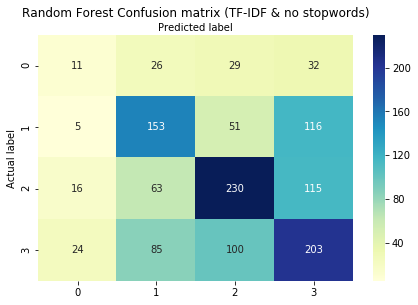

In [243]:
class_names=[0,3] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(con4_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forest Confusion matrix (TF-IDF & no stopwords)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [245]:
rf4top = pd.DataFrame(rfc4.feature_importances_, index = features4.columns, columns = ['importance']).sort_values('importance', ascending=False)
rftop

,importance
votes,0.033763
mobile,0.016295
server,0.014396
discord,0.010756
nitro,0.010514
role,0.010329
overlay,0.008992
message,0.007947
channel,0.006386
chat,0.006354


In [246]:
# Initialize Gradient Boosting- Default model 

clfp4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clfp4.fit(features4, label4)

# Predict
ypredg4 = clfp4.predict(twfeatures)


In [247]:
print(classification_report(wtlabel, ypredg4))

                     precision    recall  f1-score   support

                API       0.15      0.11      0.13        98
Account Server Mgmt       0.48      0.44      0.46       325
               Chat       0.52      0.48      0.50       424
              Other       0.42      0.50      0.46       412

        avg / total       0.45      0.45      0.45      1259



In [248]:
cong4_matrix = confusion_matrix(wtlabel, ypredg4)
cong4_matrix

array([[ 11,  22,  31,  34],
       [ 14, 143,  53, 115],
       [ 20,  65, 205, 134],
       [ 28,  70, 109, 205]])

Text(0.5, 257.44, 'Predicted label')

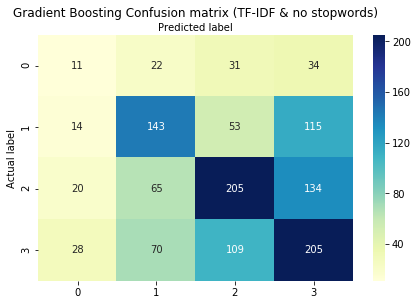

In [249]:
class_names=[0,3] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cong4_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Gradient Boosting Confusion matrix (TF-IDF & no stopwords)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [251]:
#Hyperparameter tuning
# Initalized Random Forest for TF-IDF dataset (no stopwords)
rfc4 = RandomForestClassifier(n_estimators=150, criterion= 'entropy')

# Train 
rfc4.fit(features4, label4)

# Predict 

ypred4= rfc4.predict(twfeatures)

In [252]:
print(classification_report(wtlabel, ypred4))

                     precision    recall  f1-score   support

                API       0.17      0.12      0.14        98
Account Server Mgmt       0.47      0.48      0.48       325
               Chat       0.56      0.56      0.56       424
              Other       0.44      0.46      0.45       412

        avg / total       0.47      0.47      0.47      1259



In [253]:
con4r_matrix = confusion_matrix(wtlabel, ypred4)
con4r_matrix

array([[ 12,  27,  29,  30],
       [  7, 157,  54, 107],
       [ 19,  61, 238, 106],
       [ 32,  87, 103, 190]])

Text(0.5, 257.44, 'Predicted label')

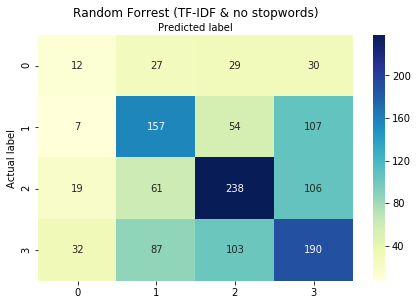

In [254]:
class_names=[0,3] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(con4r_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Forrest (TF-IDF & no stopwords)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')